#**Three Categories**

## Setup

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


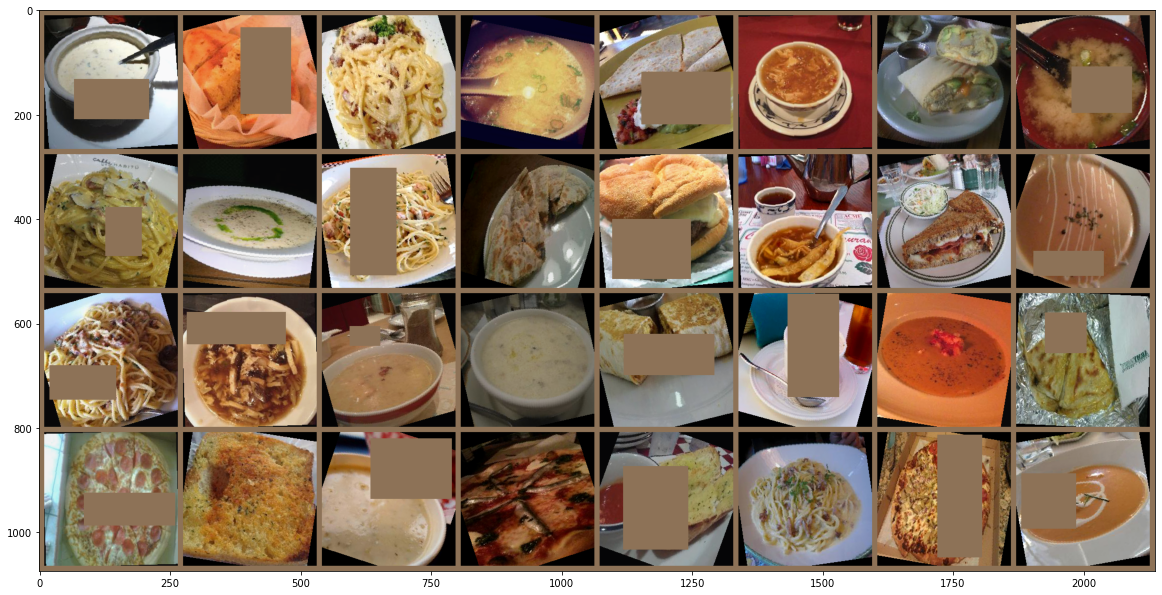

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets


ROOT_PATH = './drive/MyDrive/comp6721-project/datasets/dataset-3/'
training_path = f'{ROOT_PATH}/train'
validation_path = f'{ROOT_PATH}/val'
evaluation_path = f'{ROOT_PATH}/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
image_size = 256
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
num_classes = 3

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

# Model
model = models.resnet18(pretrained=False)
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, num_classes, device)
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

# Dataset
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

# Image samples
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Training

In [ ]:
# Training
%%time

num_epochs = 15
losses = []
accuracy = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        accuracy.append(correct / total)

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f, Accuracy: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item(), correct / total))


Epoch [ 1/15], Step [ 50/ 74], Loss: 0.8579, Accuracy: 0.5938
Epoch [ 2/15], Step [ 50/ 74], Loss: 0.8236, Accuracy: 0.6250
Epoch [ 3/15], Step [ 50/ 74], Loss: 0.7720, Accuracy: 0.5625
Epoch [ 4/15], Step [ 50/ 74], Loss: 0.7402, Accuracy: 0.6875
Epoch [ 5/15], Step [ 50/ 74], Loss: 0.7565, Accuracy: 0.7500
Epoch [ 6/15], Step [ 50/ 74], Loss: 0.8083, Accuracy: 0.6250
Epoch [ 7/15], Step [ 50/ 74], Loss: 0.6636, Accuracy: 0.7188
Epoch [ 8/15], Step [ 50/ 74], Loss: 0.5662, Accuracy: 0.7812
Epoch [ 9/15], Step [ 50/ 74], Loss: 0.6684, Accuracy: 0.7500
Epoch [10/15], Step [ 50/ 74], Loss: 0.5399, Accuracy: 0.7500
Epoch [11/15], Step [ 50/ 74], Loss: 0.8604, Accuracy: 0.6562
Epoch [12/15], Step [ 50/ 74], Loss: 0.5109, Accuracy: 0.8125
Epoch [13/15], Step [ 50/ 74], Loss: 0.5255, Accuracy: 0.7812
Epoch [14/15], Step [ 50/ 74], Loss: 0.5393, Accuracy: 0.7500
Epoch [15/15], Step [ 50/ 74], Loss: 0.4583, Accuracy: 0.8438
CPU times: user 1min 33s, sys: 10.9 s, total: 1min 44s
Wall time: 10mi

## Valuation

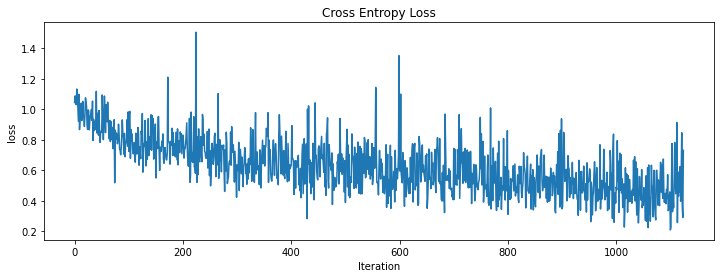

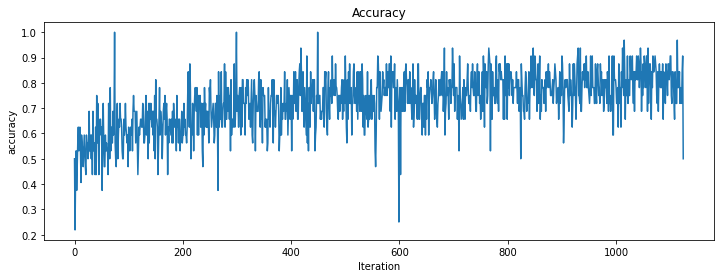

Train accuracy: 77.99
Test accuracy: 76.01
Confusion Matrix:
[[ 84   7   9]
 [ 17  21   1]
 [ 19  12 101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       100
           1       0.53      0.54      0.53        39
           2       0.91      0.77      0.83       132

    accuracy                           0.76       271
   macro avg       0.71      0.71      0.71       271
weighted avg       0.78      0.76      0.76       271



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(accuracy)
plt.xlabel('Iteration')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()


def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

## WIP: TSNE

ValueError: ignored

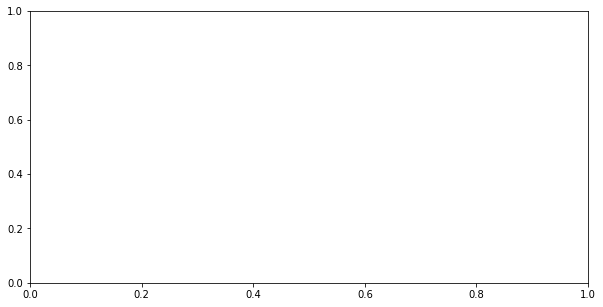

In [ ]:
%%time
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

def compute_tsne(model, dataloader):
    """
    Computes t-SNE embeddings for the given model and dataloader.
    """
    # Set model to evaluation mode
    model.eval()
    
    # Define a function to extract the features from the last layer
    def get_features_hook(module, input, output):
        features.append(output.detach().cpu().numpy())

    # Get the features from the last layer for all samples in the dataset
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            model.fc.register_forward_hook(get_features_hook)
            outputs = model(inputs)
            labels.append(targets.detach().cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
    embeddings = tsne.fit_transform(features)

    return embeddings, labels


train_embeddings, train_labels = compute_tsne(model, train_dataloader)


In [ ]:
# Plot t-SNE embeddings for the training datasets
from matplotlib.colors import ListedColormap, categorical

plt.figure(figsize=(10, 5))
cmap = ListedColormap(['r', 'g', 'b'])
plt.scatter(train_embeddings[:, 0], train_embeddings[:, 1], c=categorical(train_labels), cmap=cmap)
plt.title('Training Dataset')

ImportError: ignored

## Helper: Save/Load model

In [ ]:
# Save model
from google.colab import files

torch.save(model.state_dict(), 'checkpoint.pth')
# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Load model
from google.colab import files

state_dict = torch.load('checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
# Valuation loaded model

def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

Train accuracy: 78.88
Test accuracy: 76.01
Confusion Matrix:
[[ 84   7   9]
 [ 17  21   1]
 [ 19  12 101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       100
           1       0.53      0.54      0.53        39
           2       0.91      0.77      0.83       132

    accuracy                           0.76       271
   macro avg       0.71      0.71      0.71       271
weighted avg       0.78      0.76      0.76       271

